In [1]:
import os
import pandas as pd
import numpy as np


In [2]:
data = pd.read_csv("data/devign_base.csv")

print(data.head())

   split  bug_id  run_id    model  total_messages  function_calls  \
0  valid    1465       0  mistral              13              12   
1  valid    1035       0  mistral              15              14   
2  valid    2249       0  mistral              11              10   
3  valid     559       0  mistral               5               4   
4  valid    2619       0  mistral              10               9   

   valid_function_calls  function_repetitions  function_and_args_repetitions  \
0                     8                     0                              0   
1                    13                     8                              8   
2                     8                     1                              0   
3                     0                     0                              0   
4                     8                     1                              0   

   content_length  success  is_vulnerable  
0              -1    False          False  
1              -

In [4]:
overall_corr = data[
    [
        "total_messages",
        "function_calls",
        "valid_function_calls",
        "function_repetitions",
        "function_and_args_repetitions",
        "success",
    ]
].corr()

# Extract correlations with success
overall_corr["success"].drop("success")


total_messages                   0.053893
function_calls                   0.053893
valid_function_calls             0.044930
function_repetitions             0.051950
function_and_args_repetitions    0.048058
Name: success, dtype: float64

In [5]:
metrics = [
    "total_messages",
    "function_calls",
    "valid_function_calls",
    "function_repetitions",
    "function_and_args_repetitions",
]

all_corr_results = {}

for model, group in data.groupby("model"):
    corr_dict = {f"corr_{m}_success": group[m].corr(group["success"].astype(int)) for m in metrics}
    all_corr_results[model] = corr_dict

# Convert to DataFrame for display
all_corr_df = pd.DataFrame.from_dict(all_corr_results, orient="index").sort_index()
all_corr_df


,corr_total_messages_success,corr_function_calls_success,corr_valid_function_calls_success,corr_function_repetitions_success,corr_function_and_args_repetitions_success
gemma3,0.011519,0.011519,0.000599,0.020365,0.000249
llama3_1,0.051341,0.051341,0.059210,0.047596,0.048995
llama3_2,0.000975,0.000975,-0.003617,0.011771,0.011108
mistral,0.067700,0.067700,0.028177,0.042292,0.038102


In [7]:
spearman_corr = data[
    [
        "total_messages",
        "function_calls",
        "valid_function_calls",
        "function_repetitions",
        "function_and_args_repetitions",
        "success",
    ]
].corr(method="spearman")["success"].drop("success")
print(spearman_corr)

total_messages                   0.055809
function_calls                   0.055809
valid_function_calls             0.042339
function_repetitions             0.043207
function_and_args_repetitions    0.044791
Name: success, dtype: float64


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

In [9]:
X = data[
    [
        "total_messages",
        "function_calls",
        "valid_function_calls",
        "function_repetitions",
        "function_and_args_repetitions",
    ]
]
y = data["success"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
perm_importances = pd.Series(perm_importance.importances_mean, index=X.columns).sort_values(ascending=False)

spearman_corr, accuracy, feature_importances, perm_importances

(total_messages                   0.055809
 function_calls                   0.055809
 valid_function_calls             0.042339
 function_repetitions             0.043207
 function_and_args_repetitions    0.044791
 Name: success, dtype: float64,
 0.5319505871587616,
 valid_function_calls             0.361212
 function_repetitions             0.272136
 function_and_args_repetitions    0.190722
 function_calls                   0.089416
 total_messages                   0.086514
 dtype: float64,
 total_messages                   0.015464
 function_calls                   0.012917
 valid_function_calls             0.007137
 function_and_args_repetitions    0.002989
 function_repetitions            -0.000519
 dtype: float64)

Text(0.5, 1.0, 'Success Probability vs. Valid Function Calls')

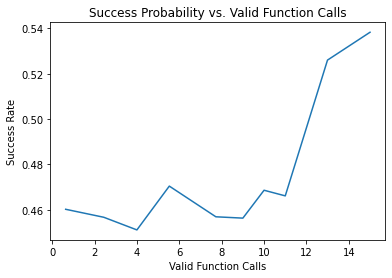

In [11]:
import matplotlib.pyplot as plt
data['length_bin'] = pd.qcut(data['valid_function_calls'], q=10)  # 10 quantile bins
success_rate = data.groupby('length_bin')['success'].mean()
bin_centers = data.groupby('length_bin')['valid_function_calls'].mean()

plt.plot(bin_centers, success_rate)
plt.xlabel('Valid Function Calls')
plt.ylabel('Success Rate')
plt.title('Success Probability vs. Valid Function Calls')

In [17]:
project_summary = data.groupby("model").agg(
    avg_valid_function_calls=("valid_function_calls", "mean"),
    median_valid_function_calls=("valid_function_calls", "median"),
    success_rate=("success", "mean"),
    count=("success", "size"),
).sort_values("success_rate", ascending=False)

project_summary


,avg_valid_function_calls,median_valid_function_calls,success_rate,count
model,,,,
mistral,10.665203,11,0.511469,8196
llama3_1,10.327721,10,0.478526,8196
gemma3,2.370303,2,0.454124,8196
llama3_2,6.023304,6,0.452904,8196


success,mean_valid_function_calls_fail,mean_valid_function_calls_success
model,,
mistral,10.552448,10.772901
llama3_1,10.164483,10.505609
llama3_2,6.031445,6.013470
gemma3,2.369245,2.371574


<Figure size 864x432 with 0 Axes>

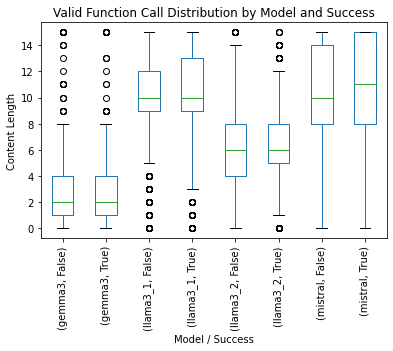

In [20]:
import matplotlib.pyplot as plt

project_success_lengths = (
    data.groupby(["model", "success"])["valid_function_calls"]
    .mean()
    .unstack()
    .rename(columns={False: "mean_valid_function_calls_fail", True: "mean_valid_function_calls_success"})
    .sort_values("mean_valid_function_calls_success", ascending=False)
)

plt.figure(figsize=(12, 6))
data.boxplot(column="valid_function_calls", by=["model", "success"], grid=False, rot=90)
plt.title("Valid Function Call Distribution by Model and Success")
plt.suptitle("")
plt.ylabel("Content Length")
plt.xlabel("Model / Success")

project_success_lengths.head(10)


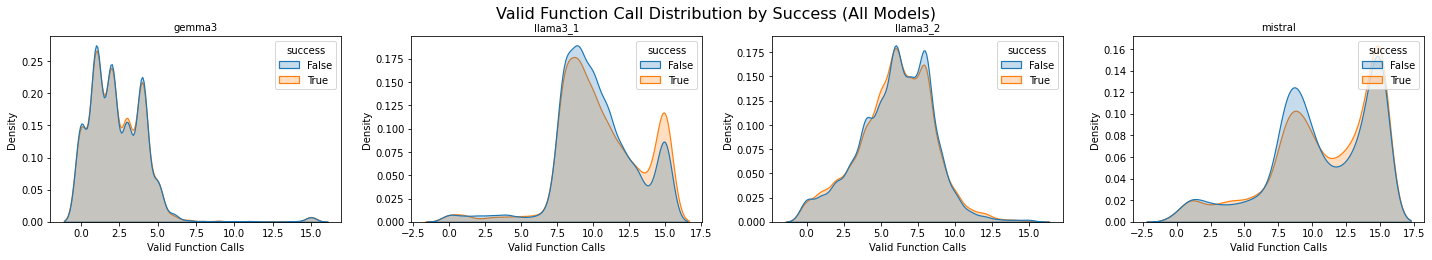

In [23]:
import math
import seaborn as sns
import matplotlib.pyplot as plt

models = sorted(data["model"].unique())
n_models = len(models)

cols = 4
rows = math.ceil(n_models / cols)

plt.figure(figsize=(5 * cols, 3.5 * rows))

for i, model in enumerate(models, 1):
    plt.subplot(rows, cols, i)
    subset = data[data["model"] == model]
    sns.kdeplot(data=subset, x="valid_function_calls", hue="success",
                common_norm=False, fill=True, linewidth=1.2)
    plt.title(model, fontsize=10)
    plt.xlabel("Valid Function Calls")
    plt.ylabel("Density")
    plt.tight_layout()

plt.suptitle("Valid Function Call Distribution by Success (All Models)", fontsize=16, y=1.02)
plt.show()


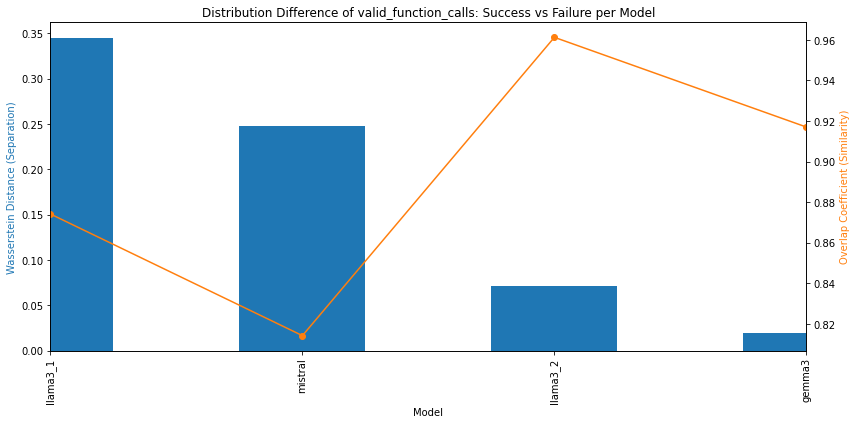

,model,wasserstein_distance,overlap_coefficient
1,llama3_1,0.344858,0.874115
3,mistral,0.248244,0.814116
2,llama3_2,0.070727,0.961293
0,gemma3,0.019496,0.917029


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance, gaussian_kde

def overlap_coefficient(x1, x2):
    kde1 = gaussian_kde(x1)
    kde2 = gaussian_kde(x2)
    xs = np.linspace(min(x1.min(), x2.min()), max(x1.max(), x2.max()), 500)
    return np.trapz(np.minimum(kde1(xs), kde2(xs)), xs)

model_differences = []

for model, subset in data.groupby("model"):
    success_vals = subset.loc[subset["success"], "valid_function_calls"].astype(float)
    fail_vals = subset.loc[~subset["success"], "valid_function_calls"].astype(float)
    if len(success_vals) > 5 and len(fail_vals) > 5:  # ensure enough samples
        w_dist = wasserstein_distance(success_vals, fail_vals)
        overlap = overlap_coefficient(success_vals, fail_vals)
        model_differences.append((model, w_dist, overlap))

diff_df = pd.DataFrame(model_differences, columns=["model", "wasserstein_distance", "overlap_coefficient"])
diff_df = diff_df.sort_values("wasserstein_distance", ascending=False)

fig, ax1 = plt.subplots(figsize=(12, 6))
diff_df.plot(x="model", y="wasserstein_distance", kind="bar", ax=ax1, color="tab:blue", legend=False)
ax1.set_ylabel("Wasserstein Distance (Separation)", color="tab:blue")
ax1.set_xlabel("Model")
ax1.tick_params(axis="x", rotation=90)

ax2 = ax1.twinx()
diff_df.plot(x="model", y="overlap_coefficient", kind="line", ax=ax2, color="tab:orange", legend=False, marker="o")
ax2.set_ylabel("Overlap Coefficient (Similarity)", color="tab:orange")

plt.title("Distribution Difference of valid_function_calls: Success vs Failure per Model")
plt.tight_layout()
plt.show()

diff_df.head(10)


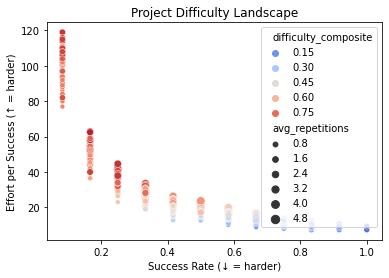

In [26]:
project_stats = data.groupby("bug_id").agg(
    success_rate=("success", "mean"),
    avg_messages=("total_messages", "mean"),
    avg_calls=("function_calls", "mean"),
    sum_valid_calls=("valid_function_calls", "sum"),
    sum_total_calls=("function_calls", "sum"),
    avg_repetitions=("function_repetitions", "mean"),
)

project_stats["avg_valid_ratio"] = project_stats["sum_valid_calls"] / project_stats["sum_total_calls"]
project_stats["effort_per_success"] = project_stats["avg_messages"] / project_stats["success_rate"].replace(0, np.nan)
project_stats["difficulty_simple"] = 1 - project_stats["success_rate"]

project_stats["difficulty_composite"] = (
    (1 - project_stats["success_rate"]) * 0.5 +
    project_stats["avg_repetitions"].rank(pct=True) * 0.25 +
    project_stats["effort_per_success"].rank(pct=True) * 0.25
)

project_difficulty = project_stats.sort_values("difficulty_composite", ascending=False)

sns.scatterplot(
    data=project_stats,
    x="success_rate",
    y="effort_per_success",
    size="avg_repetitions",
    hue="difficulty_composite",
    palette="coolwarm",
    legend="brief"
)
plt.title("Project Difficulty Landscape")
plt.xlabel("Success Rate (↓ = harder)")
plt.ylabel("Effort per Success (↑ = harder)")
plt.show()


In [31]:
from adjustText import adjust_text

plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=project_stats,
    x="success_rate",
    y="effort_per_success",
    size="avg_repetitions",
    hue="difficulty_composite",
    palette="coolwarm",
    alpha=0.6
)

texts = []
for project, row in project_stats.iterrows():
    texts.append(plt.text(row["success_rate"], row["effort_per_success"], project,
                          fontsize=8, alpha=0.9))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.title("Project Difficulty Landscape (Labeled, Adjusted Text)")
plt.xlabel("Success Rate (↓ = harder)")
plt.ylabel("Effort per Success (↑ = harder)")
plt.tight_layout()
plt.show()


SyntaxError: future feature annotations is not defined (__init__.py, line 1)

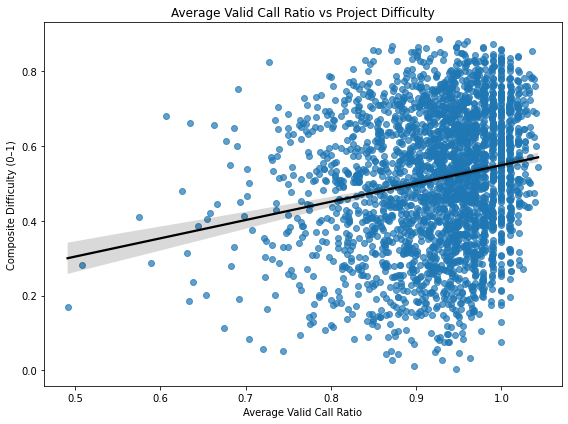

In [35]:

plt.figure(figsize=(8, 6))
sns.regplot(
    data=project_stats,
    x="avg_valid_ratio",
    y="difficulty_composite",
    scatter_kws={'alpha':0.7},
    line_kws={'color':'black'}
)

plt.title("Average Valid Call Ratio vs Project Difficulty")
plt.xlabel("Average Valid Call Ratio")
plt.ylabel("Composite Difficulty (0–1)")
plt.tight_layout()
plt.show()


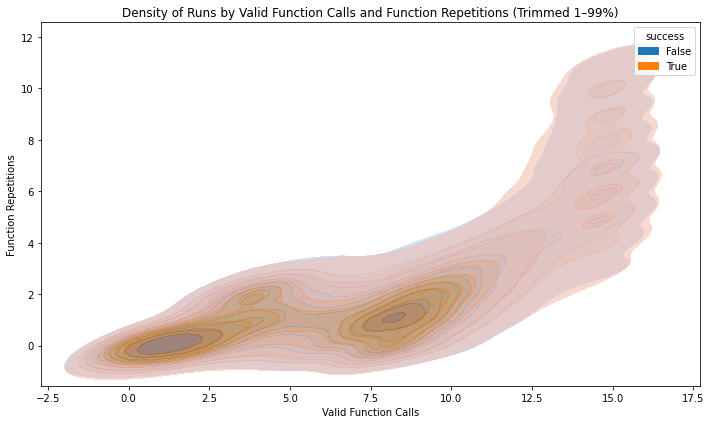

In [37]:
q_low_x, q_high_x = data["valid_function_calls"].quantile([0.01, 0.99])
q_low_y, q_high_y = data["function_repetitions"].quantile([0.01, 0.99])

data_trimmed = data[
    (data["valid_function_calls"].between(q_low_x, q_high_x)) &
    (data["function_repetitions"].between(q_low_y, q_high_y))
].copy()

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=data_trimmed,
    x="valid_function_calls",
    y="function_repetitions",
    hue="success",
    fill=True,
    alpha=0.5,
)
plt.title("Density of Runs by Valid Function Calls and Function Repetitions (Trimmed 1–99%)")
plt.xlabel("Valid Function Calls")
plt.ylabel("Function Repetitions")
plt.tight_layout()
plt.show()


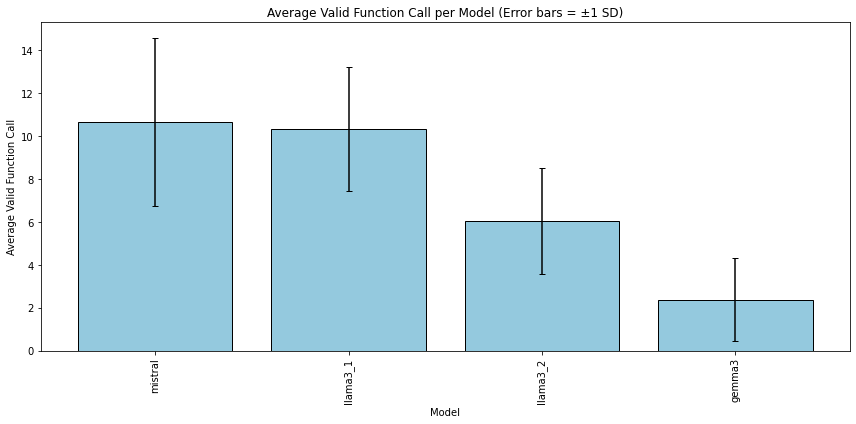

In [38]:
valid_function_call_stats = data.groupby("model")["valid_function_calls"].agg(
    avg_valid_function_calls="mean",
    std_valid_function_calls="std",
    count="size"
).sort_values("avg_valid_function_calls", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=valid_function_call_stats.reset_index(),
    x="model",
    y="avg_valid_function_calls",
    color="skyblue",
    edgecolor="black"
)
plt.errorbar(
    x=np.arange(len(valid_function_call_stats)),
    y=valid_function_call_stats["avg_valid_function_calls"],
    yerr=valid_function_call_stats["std_valid_function_calls"],
    fmt='none',
    ecolor='black',
    capsize=3
)
plt.xticks(rotation=90)
plt.title("Average Valid Function Call per Model (Error bars = ±1 SD)")
plt.xlabel("Model")
plt.ylabel("Average Valid Function Call")
plt.tight_layout()
plt.show()


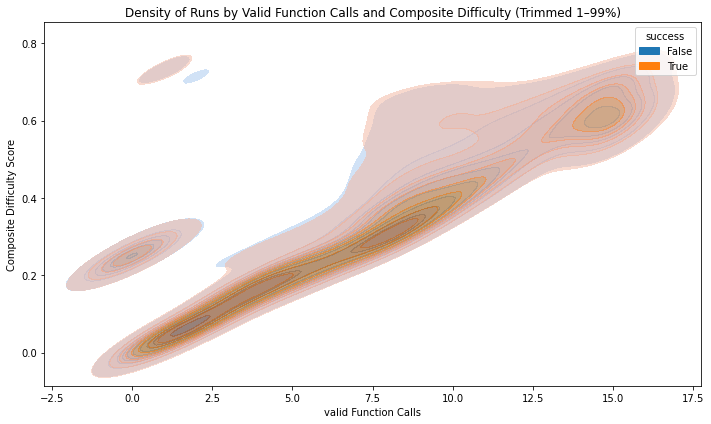

In [39]:
# GPT's recommendation
data["valid_ratio"] = data["valid_function_calls"] / data["function_calls"].replace(0, np.nan)

for col in ["total_messages", "function_calls", "function_repetitions"]:
    data[f"norm_{col}"] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

data["difficulty_score"] = (
    0.25 * data["norm_function_calls"] +
    0.25 * data["norm_function_repetitions"] +
    0.25 * data["norm_total_messages"] +
    0.25 * (1 - data["valid_ratio"].fillna(0))
)

q_low_x, q_high_x = data["valid_function_calls"].quantile([0.01, 0.99])
q_low_y, q_high_y = data["difficulty_score"].quantile([0.01, 0.99])

data_trimmed = data[
    (data["valid_function_calls"].between(q_low_x, q_high_x)) &
    (data["difficulty_score"].between(q_low_y, q_high_y))
].copy()

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=data_trimmed,
    x="valid_function_calls",
    y="difficulty_score",
    hue="success",
    fill=True,
    alpha=0.5,
)
plt.title("Density of Runs by Valid Function Calls and Composite Difficulty (Trimmed 1–99%)")
plt.xlabel("valid Function Calls")
plt.ylabel("Composite Difficulty Score")
plt.tight_layout()
plt.show()
